In [1]:
pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.


                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1


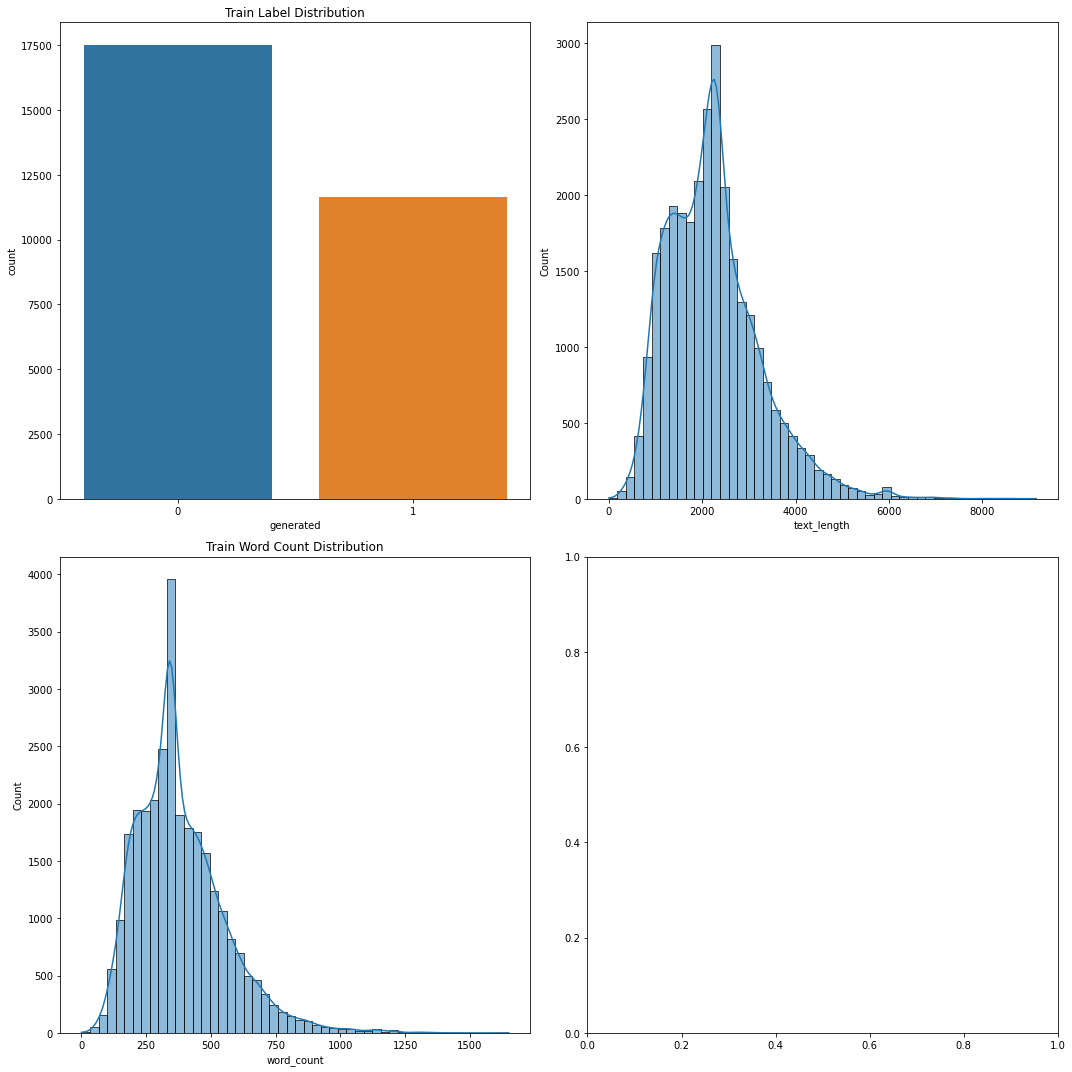

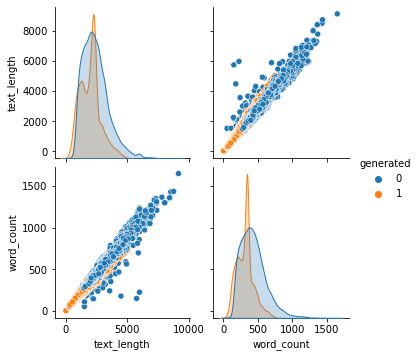

   generated  text_length_mean  text_length_std  text_length_min  \
0          0       2403.223669      1041.382417              239   
1          1       1984.401908       839.414973                1   

   text_length_max  word_count_mean  word_count_std  word_count_min  \
0             9157       430.179518      183.115058              48   
1             5078       312.379823      123.200536               1   

   word_count_max  
0            1650  
1             785  


In [2]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.util import ngrams
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize
pd.set_option('display.max_columns', None)


train_path = '../dataset/Training_Essay_Data.csv'

train_df = pd.read_csv(train_path)
print(train_df.head())
train_size = train_df.shape
train_missing_values = train_df.isnull().sum()
train_label_distribution = train_df['generated'].value_counts()

# Adding text length and word count columns
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

text_length_info_train = train_df['text_length'].describe()
word_count_info_train = train_df['word_count'].describe()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# Label distribution
sns.countplot(ax=axes[0, 0], x='generated', data=train_df)
axes[0, 0].set_title('Train Label Distribution')

# Text length distribution
sns.histplot(ax=axes[0, 1], x='text_length', data=train_df, bins=50, kde=True)
axes[1, 0].set_title('Train Text Length Distribution')

sns.histplot(ax=axes[1, 0], x='word_count', data=train_df, bins=50, kde=True)
axes[1, 0].set_title('Train Word Count Distribution')

plt.tight_layout()
plt.show()

sns.pairplot( data=train_df, hue='generated', vars=['text_length', 'word_count'])
plt.show()

#test_df.info()

grouped_data_for_train = train_df.groupby('generated').agg({
    'text_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flattening the multi-level columns
grouped_data_for_train.columns = ['generated', 'text_length_mean', 'text_length_std', 'text_length_min', 'text_length_max',
                        'word_count_mean', 'word_count_std', 'word_count_min', 'word_count_max']


# Displaying the comparison
print(grouped_data_for_train)


In [3]:
stop_words = set(stopwords.words('english'))

#clean text in various ways
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove words with 1 or 2 characters
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace

    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

# Cleaned text
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Flatten list of words for each label
all_words_train_0 = [word for sublist in train_df[train_df['generated'] == 0]['cleaned_text'] for word in sublist]
all_words_train_1 = [word for sublist in train_df[train_df['generated'] == 1]['cleaned_text'] for word in sublist]

# Get word frequency with 20 most used words for both labels
word_freq_0_in_train = Counter(all_words_train_0).most_common(40)
word_freq_1_in_train = Counter(all_words_train_1).most_common(40)

print("Common words with label 0 in training set:", word_freq_0_in_train)
print("Common words with label 1 in training set:", word_freq_1_in_train)

train_df['cleaned_text_str'] = train_df['cleaned_text'].apply(lambda x: ' '.join(x))
print(train_df)

Common words with label 0 in training set: [('people', 65692), ('would', 37836), ('electoral', 31017), ('car', 28103), ('one', 27533), ('college', 26889), ('vote', 26252), ('could', 24955), ('like', 24698), ('cars', 24627), ('get', 23490), ('venus', 22536), ('also', 21863), ('help', 21059), ('many', 20741), ('make', 20321), ('states', 19825), ('driving', 19529), ('even', 18113), ('think', 17886), ('president', 17239), ('good', 16477), ('time', 16474), ('way', 15630), ('use', 15333), ('face', 15330), ('know', 15297), ('students', 15090), ('life', 14976), ('want', 14547), ('better', 14250), ('person', 14004), ('advice', 13479), ('system', 12309), ('may', 11557), ('electors', 11364), ('day', 11338), ('votes', 11284), ('need', 11260), ('school', 11231)]
Common words with label 1 in training set: [('people', 17566), ('also', 13459), ('electoral', 12321), ('students', 11699), ('college', 11574), ('one', 11412), ('may', 10963), ('car', 9177), ('important', 9170), ('states', 9090), ('many', 85

In [4]:
train_df.to_csv(os.path.join('../dataset/detailed_data.csv'), index=False)

In [5]:
y_train = train_df['generated'].values
y_train_df = pd.DataFrame(y_train, columns=['generated'])

merged_df = pd.concat([train_df['cleaned_text_str'], y_train_df], axis=1)

merged_df.columns = ['text', 'generated']

merged_df.to_csv(os.path.join('../dataset/cleaned_data.csv'), index=False)

In [6]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
train_df['sentiment'] = train_df['cleaned_text_str'].apply(get_sentiment)

# Sentiment distribution
sentiment_distribution = train_df['sentiment'].value_counts()

# Sentiment distribution in generated and non-generated texts
sentiment_from_generated = train_df[train_df['generated'] == 1]['sentiment'].value_counts()
sentiment_from_non_generated = train_df[train_df['generated'] == 0]['sentiment'].value_counts()

print(sentiment_distribution, sentiment_from_generated, sentiment_from_non_generated)


Positive    27156
Negative     1971
Neutral        18
Name: sentiment, dtype: int64 Positive    11233
Negative      394
Neutral        10
Name: sentiment, dtype: int64 Positive    15923
Negative     1577
Neutral         8
Name: sentiment, dtype: int64


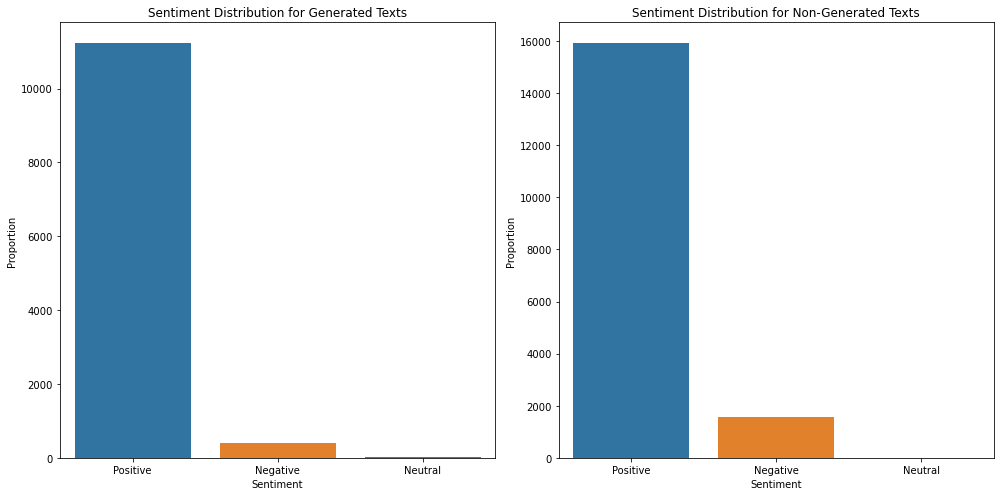

In [7]:
# Plot sentiment distribution
plt.figure(figsize=(14, 7))

# plt.subplot(1, 2, 1)
# sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
# plt.title('Overall Sentiment Distribution')
# plt.xlabel('Sentiment')
# plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# sns.barplot(x=sentiment_from_generated.index, y=sentiment_from_generated.values, alpha=0.7, label='Generated')
# sns.barplot(x=sentiment_from_non_generated.index, y=sentiment_from_non_generated.values, alpha=0.7, label='Non-Generated')
# plt.title('Sentiment Distribution: Generated vs Non-Generated')
# plt.xlabel('Sentiment')
# plt.ylabel('Count')
# plt.legend()


plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_from_generated.index, y=sentiment_from_generated.values)
plt.title('Sentiment Distribution for Generated Texts')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')

plt.subplot(1, 2, 2)
sns.barplot(x=sentiment_from_non_generated.index, y=sentiment_from_non_generated.values)
plt.title('Sentiment Distribution for Non-Generated Texts')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')


plt.tight_layout()
plt.show()